In [ ]:
# Switch to tensorflow 1.x
%tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


In [1]:

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from Compute_Jacobian import jacobian # Please download 'Compute_Jacobian.py' in the repository 
import numpy as np
import timeit
from scipy.interpolate import griddata
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name=None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name

    def sample(self, N):
        x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y

In [40]:
def u(x, a):
    return a*x**3

def u_xx(x, a):
    return 6*a*x

In [41]:
class PINN:
    def __init__(self, layers, X_u, Y_u, X_r, Y_r):
        self.mu_X, self.sigma_X = X_r.mean(0), X_r.std(0)
        self.mu_x, self.sigma_x = self.mu_X[0], self.sigma_X[0]

        # Normalize
        self.X_u = (X_u - self.mu_X) / self.sigma_X
        self.Y_u = Y_u
        self.X_r = (X_r - self.mu_X) / self.sigma_X
        self.Y_r = Y_r

        # Initialize network weights and biases
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
            
        # Define the size of the Kernel
        self.kernel_size = X_u.shape[0]
        
        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

        # Define placeholders and computational graph
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x_bc_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        
        self.x_u_ntk_tf = tf.placeholder(tf.float32, shape=(self.kernel_size, 1))
        self.x_r_ntk_tf = tf.placeholder(tf.float32, shape=(self.kernel_size, 1))


        # Evaluate predictions
        self.u_bc_pred = self.net_u(self.x_bc_tf)

        self.u_pred = self.net_u(self.x_u_tf)
        self.r_pred = self.net_r(self.x_r_tf)
        
        self.u_ntk_pred = self.net_u(self.x_u_ntk_tf)
        self.r_ntk_pred = self.net_r(self.x_r_ntk_tf)
     
        # Boundary loss
        self.loss_bcs = tf.reduce_mean(tf.square(self.u_bc_pred - self.u_bc_tf))

        # Residual loss        
        self.loss_res =  tf.reduce_mean(tf.square(self.r_tf - self.r_pred))
        
        # Total loss
        self.loss = self.loss_res + self.loss_bcs

        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-5
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                        1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        # To compute NTK, it is better to use SGD optimizer
        # since the corresponding gradient flow is not exactly same.
        self.train_op = tf.train.GradientDescentOptimizer(starter_learning_rate).minimize(self.loss)
        # self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)


        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
        self.saver = tf.train.Saver()
        
        # Compute the Jacobian for weights and biases in each hidden layer  
        self.J_u = self.compute_jacobian(self.u_ntk_pred) 
        self.J_r = self.compute_jacobian(self.r_ntk_pred)
        
        # The empirical NTK = J J^T, compute NTK of PINNs 
        self.K_uu = self.compute_ntk(self.J_u, self.x_u_ntk_tf, self.J_u, self.x_u_ntk_tf)
        self.K_ur = self.compute_ntk(self.J_u, self.x_u_ntk_tf, self.J_r, self.x_r_ntk_tf)
        self.K_rr = self.compute_ntk(self.J_r, self.x_r_ntk_tf, self.J_r, self.x_r_ntk_tf)
        
        # Logger
        # Loss logger
        self.loss_bcs_log = []
        self.loss_res_log = []

        # NTK logger 
        self.K_uu_log = []
        self.K_rr_log = []
        self.K_ur_log = []
        
        # Weights logger 
        self.weights_log = []
        self.biases_log = []
        
    # Xavier initialization
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.random.normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                           dtype=tf.float32)
    
    # NTK initialization
    def NTK_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        std = 1. / np.sqrt(in_dim)
        return tf.Variable(tf.random.normal([in_dim, out_dim], dtype=tf.float32) * std,
                           dtype=tf.float32)

     # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.NTK_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.random.normal([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass(self, H):
        num_layers = len(self.layers)
        for l in range(0, num_layers - 2):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))
        W = self.weights[-1]
        b = self.biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

    # Evaluates the PDE solution
    def net_u(self, x):
        u = self.forward_pass(x)
        return u

    # Forward pass for the residual
    def net_r(self, x):
        u = self.net_u(x)

        u_x = tf.gradients(u, x)[0] / self.sigma_x
        u_xx = tf.gradients(u_x, x)[0] / self.sigma_x

        res_u = u_xx
        return res_u
    
    # Compute Jacobian for each weights and biases in each layer and retrun a list 
    def compute_jacobian(self, f):
        J_list =[]
        L = len(self.weights)    
        for i in range(L):
            J_w = jacobian(f, self.weights[i])
            J_list.append(J_w)
     
        for i in range(L):
            J_b = jacobian(f, self.biases[i])
            J_list.append(J_b)
        return J_list
    
    # Compute the empirical NTK = J J^T
    def compute_ntk(self, J1_list, x1, J2_list, x2):
        D = x1.shape[0]
        N = len(J1_list)
        
        Ker = tf.zeros((D,D))
        for k in range(N):
            J1 = tf.reshape(J1_list[k], shape=(D,-1))
            J2 = tf.reshape(J2_list[k], shape=(D,-1))
            
            K = tf.matmul(J1, tf.transpose(J2))
            Ker = Ker + K
        return Ker
            
    # Trains the model by minimizing the MSE loss
    def train(self, nIter=10000, batch_size=128, log_NTK=True, log_weights=True):

        start_time = timeit.default_timer()
        for it in range(nIter):
            # Fetch boundary mini-batches
            # Define a dictionary for associating placeholders with data
            tf_dict = {self.x_bc_tf: self.X_u, self.u_bc_tf: self.Y_u,
                       self.x_u_tf: self.X_u, self.x_r_tf: self.X_r,
                       self.r_tf: self.Y_r
                       }
        
            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_bcs_value, loss_res_value = self.sess.run([self.loss_bcs, self.loss_res], tf_dict)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)

                print('It: %d, Loss: %.3e, Loss_bcs: %.3e, Loss_res: %.3e ,Time: %.2f' %
                      (it, loss_value, loss_bcs_value, loss_res_value, elapsed))
                

                start_time = timeit.default_timer()

            if log_NTK:
                # provide x, x' for NTK
                if it % 100 == 0:
                    print("Compute NTK...")
                    tf_dict = {self.x_u_ntk_tf: self.X_u, self.x_r_ntk_tf: self.X_r}
                    K_uu_value, K_ur_value, K_rr_value = self.sess.run([self.K_uu,
                                                                        self.K_ur,
                                                                        self.K_rr], tf_dict)
                    self.K_uu_log.append(K_uu_value)
                    self.K_ur_log.append(K_ur_value)
                    self.K_rr_log.append(K_rr_value)
                    
            if log_weights:
                if it % 100 ==0:
                    print("Weights stored...")
                    weights = self.sess.run(self.weights)
                    biases = self.sess.run(self.biases)
                    
                    self.weights_log.append(weights)
                    self.biases_log.append(biases)
                
    # Evaluates predictions at test points
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.x_u_tf: X_star}
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star

    # Evaluates predictions at test points
    def predict_r(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.x_r_tf: X_star}
        r_star = self.sess.run(self.r_pred, tf_dict)
        return r_star


In [42]:
# Define computional domain
a =1
bc1_coords = np.array([[0.0],
                       [0.0]])

bc2_coords = np.array([[1.0],
                       [1.0]])

dom_coords = np.array([[0.0],
                       [1.0]])

# Training data on u(x) -- Dirichlet boundary conditions

nn  = 100

X_bc1 = dom_coords[0, 0] * np.ones((nn // 2, 1))
X_bc2 = dom_coords[1, 0] * np.ones((nn // 2, 1))
X_u = np.vstack([X_bc1, X_bc2])
Y_u = u(X_u, a)

X_r = np.linspace(dom_coords[0, 0],
                  dom_coords[1, 0], nn)[:, None]
Y_r = u_xx(X_r, a)

In [43]:
# Define model
layers = [1, 512, 1]  
# layers = [1, 512, 512, 512, 1]  
model = PINN(layers, X_u, Y_u, X_r, Y_r)    

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



In [44]:
# Train model
model.train(nIter=40001, batch_size=100, log_NTK=True, log_weights=True)

It: 0, Loss: 6.065e+01, Loss_bcs: 8.025e-02, Loss_res: 6.057e+01 ,Time: 1.28
Compute NTK...
Weights stored...
It: 100, Loss: 7.046e+00, Loss_bcs: 4.339e-01, Loss_res: 6.613e+00 ,Time: 0.62
Compute NTK...
Weights stored...
It: 200, Loss: 3.176e+00, Loss_bcs: 7.755e-01, Loss_res: 2.401e+00 ,Time: 0.46
Compute NTK...
Weights stored...
It: 300, Loss: 2.148e+00, Loss_bcs: 8.640e-01, Loss_res: 1.284e+00 ,Time: 0.32
Compute NTK...
Weights stored...
It: 400, Loss: 1.700e+00, Loss_bcs: 8.320e-01, Loss_res: 8.676e-01 ,Time: 0.27
Compute NTK...
Weights stored...
It: 500, Loss: 1.422e+00, Loss_bcs: 7.551e-01, Loss_res: 6.671e-01 ,Time: 0.24
Compute NTK...
Weights stored...
It: 600, Loss: 1.220e+00, Loss_bcs: 6.667e-01, Loss_res: 5.534e-01 ,Time: 0.30
Compute NTK...
Weights stored...
It: 700, Loss: 1.062e+00, Loss_bcs: 5.806e-01, Loss_res: 4.811e-01 ,Time: 0.28
Compute NTK...
Weights stored...
It: 800, Loss: 9.341e-01, Loss_bcs: 5.016e-01, Loss_res: 4.325e-01 ,Time: 0.39
Compute NTK...
Weights stor

**Training Loss**

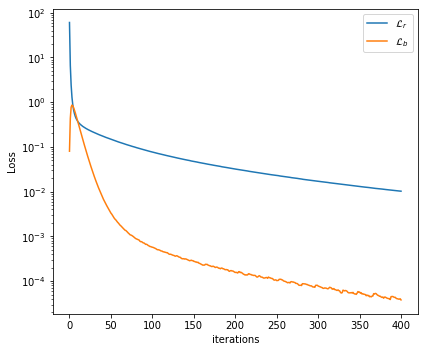

In [45]:
loss_bcs = model.loss_bcs_log
loss_res = model.loss_res_log

fig = plt.figure(figsize=(6,5))
plt.plot(loss_res, label='$\mathcal{L}_{r}$')
plt.plot(loss_bcs, label='$\mathcal{L}_{b}$')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

**Model Prediction**

In [46]:
nn = 1000
X_star = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
u_star = u(X_star, a)
r_star = u_xx(X_star, a)

# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_r = np.linalg.norm(r_star - r_pred, 2) / np.linalg.norm(r_star, 2)

print('Relative L2 error_u: {:.2e}'.format(error_u))
print('Relative L2 error_r: {:.2e}'.format(error_r))

Relative L2 error_u: 1.14e-02
Relative L2 error_r: 2.64e-02


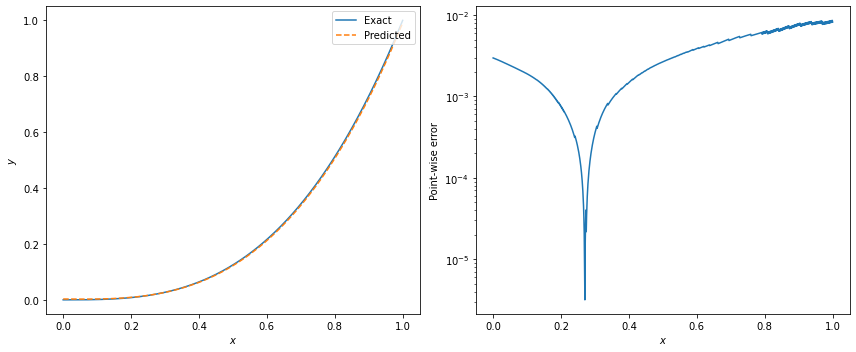

In [47]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(X_star, u_star, label='Exact')
plt.plot(X_star, u_pred, '--', label='Predicted')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(X_star, np.abs(u_star - u_pred), label='Error')
plt.yscale('log')
plt.xlabel('$x$')
plt.ylabel('Point-wise error')
plt.tight_layout()
plt.show()

**NTK Eigenvalues**

In [48]:
# Create empty lists for storing the eigenvalues of NTK
lambda_K_log = []
lambda_K_uu_log = []
lambda_K_ur_log = []
lambda_K_rr_log = []

# Restore the NTK
K_uu_list = model.K_uu_log
K_ur_list = model.K_ur_log
K_rr_list = model.K_rr_log
K_list = []
    
for k in range(len(K_uu_list)):
    K_uu = K_uu_list[k]
    K_ur = K_ur_list[k]
    K_rr = K_rr_list[k]
    
    K = np.concatenate([np.concatenate([K_uu, K_ur], axis = 1),
                        np.concatenate([K_ur.T, K_rr], axis = 1)], axis = 0)
    K_list.append(K)

    # Compute eigenvalues
    lambda_K, _ = np.linalg.eig(K)
    lambda_K_uu, _ = np.linalg.eig(K_uu)
    lambda_K_rr, _ = np.linalg.eig(K_rr)
    
    # Sort in descresing order
    lambda_K = np.sort(np.real(lambda_K))[::-1]
    lambda_K_uu = np.sort(np.real(lambda_K_uu))[::-1]
    lambda_K_rr = np.sort(np.real(lambda_K_rr))[::-1]
    
    # Store eigenvalues
    lambda_K_log.append(lambda_K)
    lambda_K_uu_log.append(lambda_K_uu)
    lambda_K_rr_log.append(lambda_K_rr)

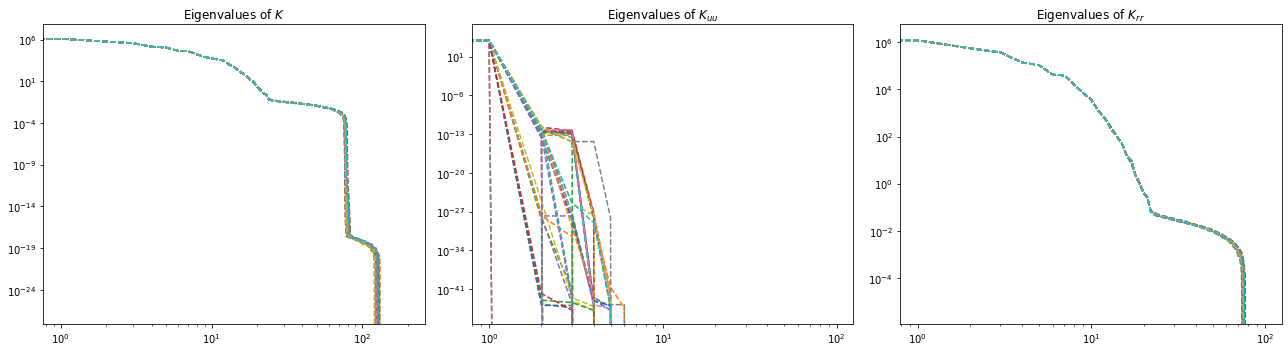

In [49]:
fig = plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)
for i in range(1, len(lambda_K_log), 10):
    plt.plot(lambda_K_log[i], '--')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}$')
plt.tight_layout()

plt.subplot(1,3,2)
for i in range(1, len(lambda_K_uu_log), 10):
    plt.plot(lambda_K_uu_log[i], '--')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}_{uu}$')
plt.tight_layout()

plt.subplot(1,3,3)
for i in range(1, len(lambda_K_log), 10):
    plt.plot(lambda_K_rr_log[i], '--')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}_{rr}$')
plt.tight_layout()
plt.show()

**Change of NTK**

In [50]:
# Change of the NTK
NTK_change_list = []
K0 = K_list[0]
for K in K_list:
    diff = np.linalg.norm(K - K0) / np.linalg.norm(K0) 
    NTK_change_list.append(diff)

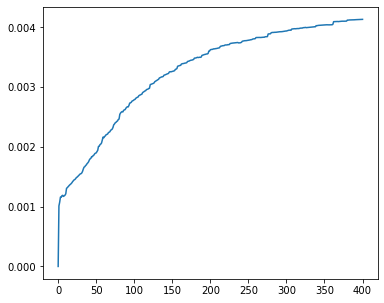

In [51]:
fig = plt.figure(figsize=(6,5))
plt.plot(NTK_change_list)


**Change of NN Params**

In [52]:
# Change of the weights and biases
def compute_weights_diff(weights_1, weights_2):
    weights = []
    N = len(weights_1)
    for k in range(N):
        weight = weights_1[k] - weights_2[k]
        weights.append(weight)
    return weights

def compute_weights_norm(weights, biases):
    norm = 0
    for w in weights:
        norm = norm + np.sum(np.square(w))
    for b in biases:
        norm = norm + np.sum(np.square(b))
    norm = np.sqrt(norm)
    return norm

# Restore the list weights and biases
weights_log = model.weights_log
biases_log = model.biases_log

weights_0 = weights_log[0]
biases_0 = biases_log[0]

# Norm of the weights at initialization
weights_init_norm = compute_weights_norm(weights_0, biases_0)

weights_change_list = []

N = len(weights_log)
for k in range(N):
    weights_diff = compute_weights_diff(weights_log[k], weights_log[0])
    biases_diff = compute_weights_diff(biases_log[k], biases_log[0])
    
    weights_diff_norm = compute_weights_norm(weights_diff, biases_diff)
    weights_change = weights_diff_norm / weights_init_norm
    weights_change_list.append(weights_change)

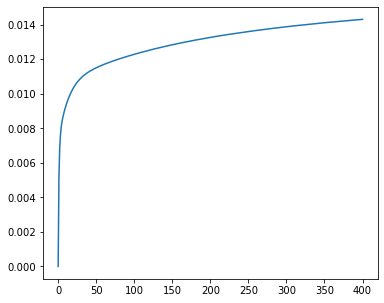

In [53]:
fig = plt.figure(figsize=(6,5))
plt.plot(weights_change_list)